# Minimum example for end-to-end learning with pypsps (with Kang-Schafer)

In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf
import tensorflow.keras as tfk

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

2023-12-11 12:14:36.133505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 12:14:36.170405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 12:14:36.171127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 12:14:39.490848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pypsps
import pypsps.datasets
import pypsps.keras.models
import pypsps.inference

# Simulating data

In [4]:
np.random.seed(10)
ks_sampler = pypsps.datasets.KangSchafer(true_ate=20)
ks_data = ks_sampler.sample(n_samples=1000)
ks_data.to_data_frame().head()

,outcome,treatment,z1,z2,z3,z4,x1,x2,x3,x4
0,253.328239,1,1.331587,0.715279,-1.545400,-0.008384,1.946034,10.149420,0.138740,428.775506
1,222.110243,0,0.621336,-0.720086,0.265512,0.108549,1.364336,9.748346,0.223205,375.912496
2,229.475001,0,0.004291,-0.174600,0.433026,1.203037,1.002148,9.912887,0.216080,442.195170
3,228.387802,1,-0.965066,1.028274,0.228630,0.445138,0.617218,10.744609,0.206608,461.107410
4,205.949273,1,-1.136602,0.135137,1.484537,-1.079805,0.566487,10.102306,0.151000,363.105677


In [5]:
# Naive ATE
ks_data.naive_ate()

-1.281692053807916

# Building a PSPS model for binary treatment and continous outcome

In [6]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(
    n_states=4, n_features=ks_data.n_features, compile=True, alpha=10.
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 4)           16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 features_and_treatment (Concat  (None, 5)           0           ['batch_normalization[0][0]',

In [8]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training model

In [9]:
inputs, outputs = ks_data.to_keras_inputs_outputs()
history = model.fit(inputs,
                    outputs,
                    epochs=250,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2,
                    callbacks=pypsps.keras.models.recommended_callbacks(),
                   )

Epoch 1/250
13/13 - 8s - loss: 48291.6055 - propensity_score_crossentropy: 0.8912 - val_loss: 42471.3711 - val_propensity_score_crossentropy: 1.1384 - lr: 0.0100 - 8s/epoch - 589ms/step
Epoch 2/250
13/13 - 0s - loss: 39970.5859 - propensity_score_crossentropy: 1.8219 - val_loss: 34071.8945 - val_propensity_score_crossentropy: 2.7909 - lr: 0.0100 - 141ms/epoch - 11ms/step
Epoch 3/250
13/13 - 0s - loss: 31131.0332 - propensity_score_crossentropy: 3.7980 - val_loss: 25489.7871 - val_propensity_score_crossentropy: 4.8516 - lr: 0.0100 - 142ms/epoch - 11ms/step
Epoch 4/250
13/13 - 0s - loss: 22735.9121 - propensity_score_crossentropy: 5.4521 - val_loss: 17649.1484 - val_propensity_score_crossentropy: 6.0100 - lr: 0.0100 - 138ms/epoch - 11ms/step
Epoch 5/250
13/13 - 0s - loss: 15524.8340 - propensity_score_crossentropy: 6.3273 - val_loss: 10982.7324 - val_propensity_score_crossentropy: 6.4094 - lr: 0.0100 - 133ms/epoch - 10ms/step
Epoch 6/250
13/13 - 0s - loss: 9716.7061 - propensity_score_cr

## Model convergence evaluation

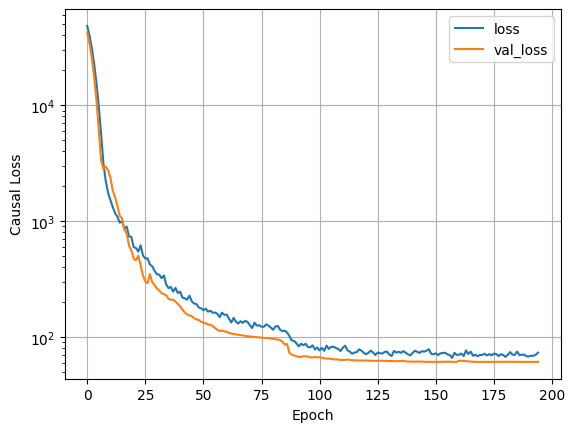

In [10]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Causal Loss")
plt.grid()

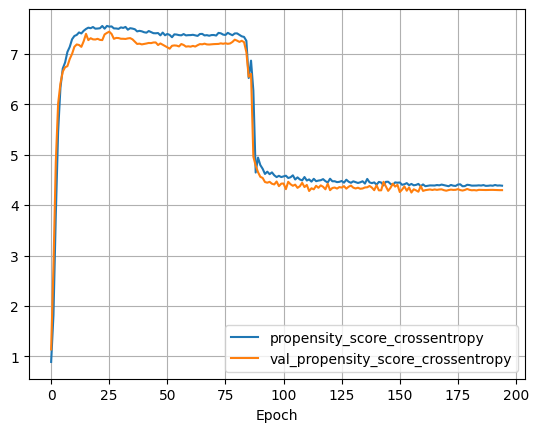

In [11]:
pd.DataFrame(history.history)[["propensity_score_crossentropy", "val_propensity_score_crossentropy"]].plot()
plt.xlabel("Epoch")
plt.grid()

## Causal predictions & inference

In [12]:
preds = model.predict(inputs)
outcome_pred, const_scale, propensity_score, weights = pypsps.utils.split_y_pred(preds)

32/32 [==============================] - 0s 2ms/step


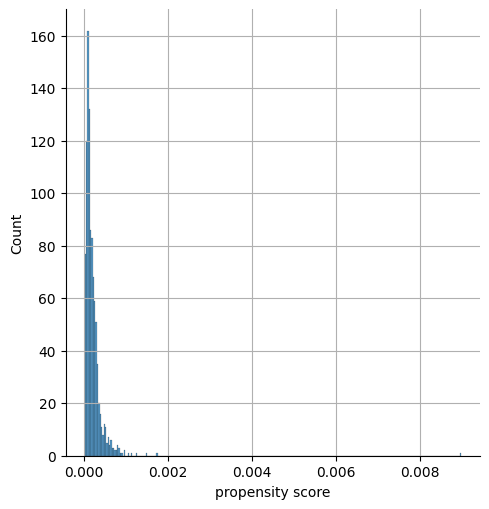

In [13]:
sns.displot(pd.Series(propensity_score.ravel()))
plt.xlabel("propensity score")
plt.grid()

<Axes: >

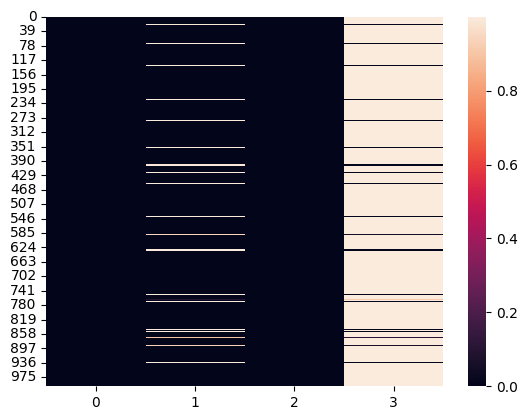

In [14]:
sns.heatmap(weights)

In [15]:
pred_ate = pypsps.inference.predict_ate(model, inputs[0])
print("True ATE: %f; predicted ATE: %f" % (ks_data.true_ate, pred_ate))

32/32 [==============================] - 0s 2ms/step
True ATE: 20.000000; predicted ATE: 17.049696
